# Imports 

In [1]:
from json import dumps
from requests import get
from http import HTTPStatus
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# Activity 1
## 1.1 Sub-activity: Open Data COVID-19 API
### Task 1

In [2]:
""" <reference>
        <function name> get_API_data </function name>
        <source> 
        <SourceCodeCategory> python </SourceCodeCategory>
        <URL> https://coronavirus.data.gov.uk/details/developers-guide/main-api </URL>
        </source>
        </reference>
"""
def get_API_data(filters: dict, structure: dict)->list:
    """
        Request data from Gov resource
        :param filters: pass the query.
        :param structure: specify what information the query should return.
        :return:
    """
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    filters = [key + "=" + filters[key] for key in filters.keys()]
    api_params = {
        "filters": str.join(";", filters),
        "structure": dumps(structure, separators=(",", ":")),
    }
    data = list()

    page_number = 1

    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = get(endpoint, params=api_params, timeout=10)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        current_data = response.json()
        page_data: List[StructureType] = current_data['data']

        data.extend(page_data)
        
        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1
        
    return data

### Task 2

In [3]:
national_filters = {"areaType": "nation"}
data_structure = {
        "date": "date",
        "name": "areaName",
        "daily_cases": "newCasesBySpecimenDate",
        "cumulative_cases": "cumCasesBySpecimenDate",
        "daily_deaths": "newDeaths28DaysByPublishDate",
        "cumulative_deaths": "cumDeaths28DaysByPublishDate",
        "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
        "vaccination_age": "vaccinationsAgeDemographics"
}
results_json_national = get_API_data(national_filters, data_structure)
regional_filters = {
        "areaType": "region"
}
results_json_regional = get_API_data(regional_filters, data_structure)
print("Information retrieval finished.")

Information retrieval finished.


## 1.1 Sub-activity: Open Data COVID-19 API
### Task 3

In [4]:
# Concatenate the two lists of dictionaries into a single list.
# By simply using + .
results_json = results_json_national + results_json_regional
print("There are {} items nation-wise, {} items region-wise, and {} items in total."
      .format(len(results_json_national), len(results_json_regional), len(results_json)))

There are 2800 items nation-wise, 6322 items region-wise, and 9122 items in total.


### Task 4

In [5]:
# Transform this list into dataframe
covid_data = pd.DataFrame(results_json)
print("There are {} rows in this dataframe".format(len(covid_data)))

There are 9122 rows in this dataframe


### Task 5

In [6]:
# Data overlaps, the delete the rows containing "England"
covid_data = covid_data[covid_data["name"] != "England"]
print("There are {} rows(records) after deleting rows containing England.".format(len(covid_data)))

There are 8399 rows(records) after deleting rows containing England.


### Task 6

In [7]:
# Using an inplace to make sure the variable is changed rather than creating a new one.
covid_data.rename(columns={"name": "area"}, inplace=True)
print("Successfully rename the column.")

Successfully rename the column.


### Task 7


In [8]:
# pd.to_datetime does not have inplace attribute, therefore it is a must to re-assign the original column manually
covid_data["date"] = pd.to_datetime(covid_data["date"])
print("Successfully change the data type to {}".format(covid_data.dtypes["date"]))

Successfully change the data type to datetime64[ns]


### Task 8

In [9]:
# To calculate the amount of null value column-wise. 
covid_data.loc[covid_data['vaccination_age'].map(lambda d: d == []), "vaccination_age"] = np.nan
missing_data_row_before_fill = covid_data.isnull().sum(axis=1)
missing_data_column_before_fill = covid_data.isnull().sum(axis=0)
print("Following dataframe shows missing data amounts per column")
print(missing_data_column_before_fill)

# To show the ratio of missing data. 
print()
missing_data_column_before_fill/len(covid_data)

Following dataframe shows missing data amounts per column
date                        0
area                        0
daily_cases                13
cumulative_cases           13
daily_deaths             1698
cumulative_deaths        1667
cumulative_vaccinated    4215
vaccination_age          4309
dtype: int64



date                     0.000000
area                     0.000000
daily_cases              0.001548
cumulative_cases         0.001548
daily_deaths             0.202167
cumulative_deaths        0.198476
cumulative_vaccinated    0.501845
vaccination_age          0.513037
dtype: float64

### Task 9

In [10]:
areas = covid_data.area.unique()
# For cumulatvive metrics
for area in areas:
    covid_data.loc[covid_data["area"] == area, "cumulative_deaths"] = covid_data[covid_data["area"]==area]["cumulative_deaths"].fillna(method="bfill")
    covid_data.loc[covid_data["area"] == area, "cumulative_cases"] = covid_data[covid_data["area"]==area]["cumulative_cases"].fillna(method="bfill")
    covid_data.loc[covid_data["area"] == area, "cumulative_vaccinated"] = covid_data[covid_data["area"]==area]["cumulative_vaccinated"].fillna(method="bfill")
print("Data filling finished.")

# Compare the null value number with previous cell outcome
print("The null value amounts column-wise")
missing_data_row_after_fill = covid_data.isnull().sum(axis=1)
missing_data_column_after_fill = covid_data.isnull().sum(axis=0)
# print(missing_data_row_after_fill)
print(missing_data_column_after_fill)

print("The null value ratio.")
print(missing_data_column_after_fill/len(covid_data))
print("The different between after filling and before filling")
print(missing_data_column_before_fill - missing_data_column_after_fill)


# Drop duplicates, using date and area to indentify a row. 
# covid_data = covid_data.drop_duplicates(subset=["date","area"])
duplicated_row = covid_data[covid_data.duplicated(subset=["date","area"])]
if len(duplicated_row) != 0:
    print("DataFrame length before droping duplicated rows is {}\n".format(len(covid_data)))
    print("There are duplicated rows")
    print(covid_data[covid_data.duplicated(subset=["date","area"])][["date","area"]], end="\n\n")
    print("Drop duplicated rows.\n")
    covid_data = covid_data.drop_duplicates(subset=["date","area"])
    print("DataFrame length after droping duplicated rows is {}".format(len(covid_data)))



Data filling finished.
The null value amounts column-wise
date                        0
area                        0
daily_cases                13
cumulative_cases            0
daily_deaths             1698
cumulative_deaths        1651
cumulative_vaccinated    3550
vaccination_age          4309
dtype: int64
The null value ratio.
date                     0.000000
area                     0.000000
daily_cases              0.001548
cumulative_cases         0.000000
daily_deaths             0.202167
cumulative_deaths        0.196571
cumulative_vaccinated    0.422669
vaccination_age          0.513037
dtype: float64
The different between after filling and before filling
date                       0
area                       0
daily_cases                0
cumulative_cases          13
daily_deaths               0
cumulative_deaths         16
cumulative_vaccinated    665
vaccination_age            0
dtype: int64
DataFrame length before droping duplicated rows is 8399

There are duplicated ro

### Task 10

In [11]:
# Remove the rows taht still have missing values in the cumulative metrics columns mentioned in the last question
covid_data = covid_data[~covid_data["cumulative_deaths"].isnull() & ~covid_data["cumulative_cases"].isnull() & ~covid_data["cumulative_vaccinated"].isnull()]
missing_data_column_after_fill = covid_data.isnull().sum(axis=0)

print("show null value amounts")
print(missing_data_column_after_fill)
print("show null value ratio")
print(missing_data_column_after_fill/len(covid_data))
print("Now there are {} rows in this dataframe".format(len(covid_data)))

show null value amounts
date                       0
area                       0
daily_cases               12
cumulative_cases           0
daily_deaths               0
cumulative_deaths          0
cumulative_vaccinated      0
vaccination_age          778
dtype: int64
show null value ratio
date                     0.000000
area                     0.000000
daily_cases              0.002475
cumulative_cases         0.000000
daily_deaths             0.000000
cumulative_deaths        0.000000
cumulative_vaccinated    0.000000
vaccination_age          0.160479
dtype: float64
Now there are 4848 rows in this dataframe


### Task11

In [12]:
# Rest the index with date
temp_covid_data = covid_data.set_index("date")

# Make sure using previous data not following data 
temp_covid_data = temp_covid_data.sort_values(by = ["date", "area"])
# TODO the order. 
groupby_result = temp_covid_data.groupby("area").rolling(7, min_periods = 1).mean()[["daily_cases","daily_deaths"]]

# Reset the column name with inplace = True attribute
groupby_result.rename(columns = {"daily_cases":"daily_cases_roll_avg", "daily_deaths":"daily_deaths_roll_avg"}, inplace=True)
groupby_result = groupby_result.reset_index()

# Avoid merge twice
if "daily_cases_roll_avg" not in covid_data.columns and "daily_deaths_roll_avg" not in covid_data.columns:
    covid_data = pd.merge(groupby_result, covid_data, how ="right", on=["date", "area"])

### Task12

In [13]:
# Drop columns daily_deaths and daily_cases
covid_data = covid_data.drop(columns=["daily_deaths", "daily_cases"])


### Task 13

In [14]:
# A column in the dataframe covid data has dictionaries as values. 
# We can transform this column into a separate dataframe. 
# Copy the columns date, area,
covid_data_vaccinations = covid_data[["date","area","vaccination_age"]]
# Drop the vaccination column from covid_data
covid_data.drop(columns=["vaccination_age"])

print("There are {} rows in covid_data_vaccinations before dumping rows containing null.".format(len(covid_data_vaccinations)))
# drop null cell.
covid_data_vaccinations=covid_data_vaccinations[~covid_data_vaccinations.vaccination_age.isnull()]
print("There are {} rows in covid_data_vaccinations after dumping rows containing null.".format(len(covid_data_vaccinations)))


There are 4848 rows in covid_data_vaccinations before dumping rows containing null.
There are 4070 rows in covid_data_vaccinations after dumping rows containing null.


### Task 14

In [15]:
list_of_vaccination_age = []
for row in covid_data_vaccinations.iterrows():
    area = row[1]["area"]
    date = row[1]["date"]
    # When the vaccination_age is a List 
    if isinstance(row[1]["vaccination_age"], list):
        for item in row[1]["vaccination_age"]:
            item["area"] = area
            item["date"] = date
            list_of_vaccination_age.append(item)
    # when the vaccination_age is a Dict
    elif isinstance(row[1]["vaccination_age"], dict):
            row[1]["vaccination_age"]["area"] = area
            row[1]["vaccination_age"]["date"] = date
            list_of_vaccination_age.append(row[1]["vaccination_age"])

covid_data_vaccinations_wide = pd.DataFrame(list_of_vaccination_age)
covid_data_vaccinations_wide = covid_data_vaccinations_wide[["date", "area","age","VaccineRegisterPopulationByVaccinationDate","cumPeopleVaccinatedCompleteByVaccinationDate","newPeopleVaccinatedCompleteByVaccinationDate","cumPeopleVaccinatedFirstDoseByVaccinationDate","newPeopleVaccinatedFirstDoseByVaccinationDate","cumPeopleVaccinatedSecondDoseByVaccinationDate","newPeopleVaccinatedSecondDoseByVaccinationDate","cumVaccinationFirstDoseUptakeByVaccinationDatePercentage","cumVaccinationCompleteCoverageByVaccinationDatePercentage","cumVaccinationSecondDoseUptakeByVaccinationDatePercentage"]]
# Each row must represent available vaccination metrics for all. 
covid_data_vaccinations_wide = covid_data_vaccinations_wide[~covid_data_vaccinations_wide.isnull().any(axis=1)]
print("There are {} rows in covid_data_vaccinations_wide".format(len(covid_data_vaccinations_wide)))


There are 67245 rows in covid_data_vaccinations_wide


## 1.3 Sub-activity: Aggregating, plotting, and analysing
### Task 15

(18601.0, 19016.0)

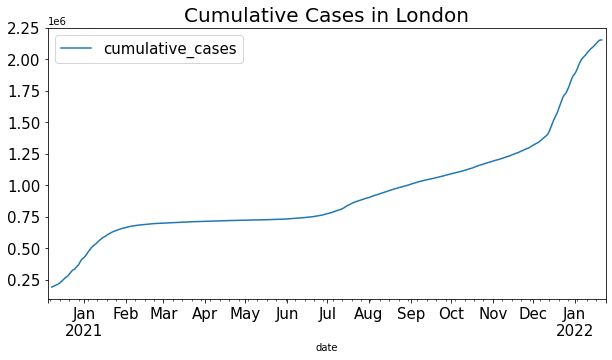

In [16]:
# 1. Aggregate the data as an intermediate dataframe
cumulative_cases_in_london = covid_data[covid_data["area"] == "London"][["date", "cumulative_cases"]]

# 2. Plot to visualised the transformed data
ax = cumulative_cases_in_london.plot(kind="line",x="date",y= "cumulative_cases", figsize = (10,5),fontsize = 15)
plt.title("Cumulative Cases in London",size=20)
plt.legend(loc=2, prop={'size': 15})
ax.set_xlim(min(cumulative_cases_in_london.date) - pd.Timedelta(days=3), max(cumulative_cases_in_london.date) + pd.Timedelta(days=3))



**3. Answer the question** <br>
Yes, there is a period of time when cases plateaued.<br>
As we can see, the cases plateaued from Feb 2021 to late June 2021, approximately, staying at around 8e+5.

### Task16

(18601.0, 19016.0)

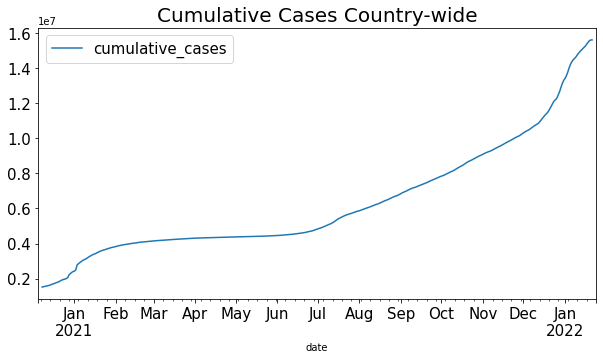

In [17]:
# 1. Aggregate the data as an intermediate dataframe
cumulative_cases_UK = covid_data[["date", "cumulative_cases"]]
# sum by date
cumulative_cases_UK = cumulative_cases_UK.groupby("date").sum()

# 2. Plot to visualised the transformed data
ax = cumulative_cases_UK.plot(kind="line",y= "cumulative_cases", figsize=(10,5), fontsize = 15)
plt.title("Cumulative Cases Country-wide",size=20)
plt.legend(loc=2, prop={'size': 15})

ax.set_xlim(min(cumulative_cases_UK.index) - pd.Timedelta(days=3), max(cumulative_cases_UK.index) + pd.Timedelta(days=3))


**3. Answer the question** <br>
As we can see, 2 graphs are very similar.<br> 
Both graphs increased from late 2020 to Feb 2021. And then, both reached a plateaue in Feb.<br>
After late June, both lines increased at a fast rate.

### Task 17

(18601.0, 19016.0)

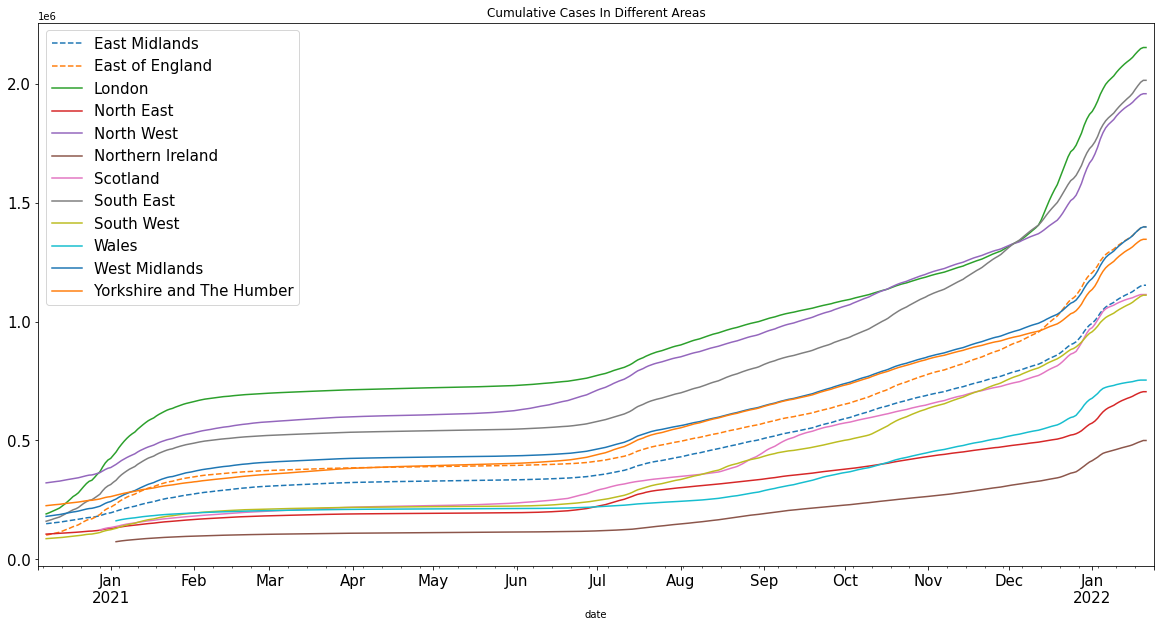

In [18]:
# 1. Aggregate the data as an intermediate dataframe
cumulative_cases_in_different_region = covid_data[["date", "area", "cumulative_cases"]].set_index(["date", "area"]).unstack()
cumulative_cases_in_different_region.columns = cumulative_cases_in_different_region.columns.droplevel()

# 2.Plot to visualised the transformed data

# Since there are only 10 colors, so make first 2 lines dashed.
ax = cumulative_cases_in_different_region.plot.line(style = ['--' for _ in range(2)], figsize = (20,10),fontsize = 15)
plt.title("Cumulative Cases In Different Areas")
plt.legend(loc=2, prop={'size': 15})
ax.set_xlim(min(cumulative_cases_in_different_region.index) - pd.Timedelta(days=3), max(cumulative_cases_in_different_region.index) + pd.Timedelta(days=3))

**3. Answer the question** <br>
Generally they all increased at first, and stayed steady for several months, but all surged after Jul 2021. <br>
The numbers of cases in all areas across the country increased fast before Feb, 2021.<br> And then stayed almost steady from Feb 2021 to late June 2021. <br>
Then, the numbers started to increase fast again after Jul 2021.

### Task 18
**Question** <br>
As a data scientist you will often need to interpret data insights, based on your own judgement and expertise. Considering the data and plot from the last question, what event could have taken place in June-July that could justify the trend seen from there onward?
<br>
<br>
**Answer** <br>
After late June, early July, the numbers of cases increased at a very fast rate. <br>
First factor is the unlock of the UK, making people exposed to COVID-19 virus, contributing to the COVID-19 cases increase. <br>
The second factor is the spread of SARS-CoV-2 Delta variant, since this variant is more contagious, and people are more likely to be infected, especially vulnerable ones.


### Task 19

(18601.0, 19016.0)

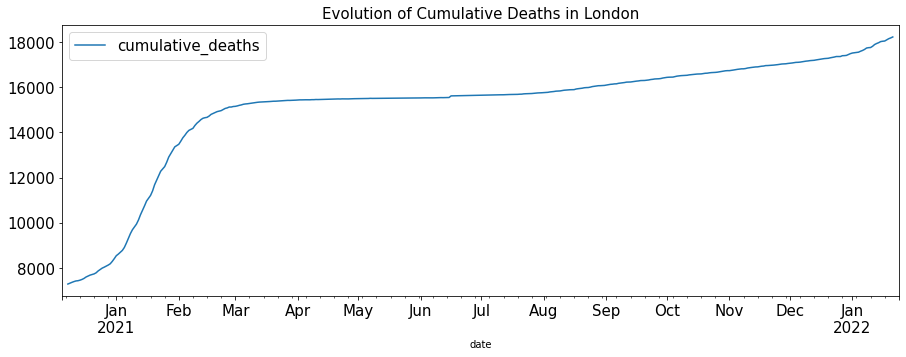

In [19]:
# 1. Aggregate the data as an intermediate dataframe
cumulative_deaths_in_london = covid_data[covid_data["area"] == "London"][["date", "cumulative_deaths"]]

# 2.Plot to visualised the transformed data
ax = cumulative_deaths_in_london.plot(x="date", figsize = (15, 5), fontsize = 15)
plt.title("Evolution of Cumulative Deaths in London", fontsize = 15)
plt.legend(loc=2, prop={'size': 15})
ax.set_xlim(min(cumulative_deaths_in_london.date) - pd.Timedelta(days=3), max(cumulative_deaths_in_london.date) + pd.Timedelta(days=3))


**3.Answer the question** <br>
Yes, there are 2 periods.
<br>
the first period when ongoing trend is broken is approxiamately late Feb, 2021. After Feb 2021, the increse became slight. 
<br>
While the latter one is late Jun 2021, the increase after that time point became larger than that in the period from late Feb 2021 to late June 2021.

### Task 20
**Question** <br>
Based on the data and plot from the last question, is there any similarity between trends in cumulative cases and cumulative deaths?
<br>
<br>
**Answer the question** <br>
There are both 3 types of trends in these two lines. <br>
First one, both 2 numbers ascended quickly before Feb 2021. <br>
Second one, both 2 numbers reached plateaue and did not increase largely until late Jul 2021. <br>
After Jul 2021, the the cumulative cases and cumulative deaths begin increase noticeably again. While the the amounts of cumulative cases increased much larger.

### Task 21

(18601.0, 19016.0)

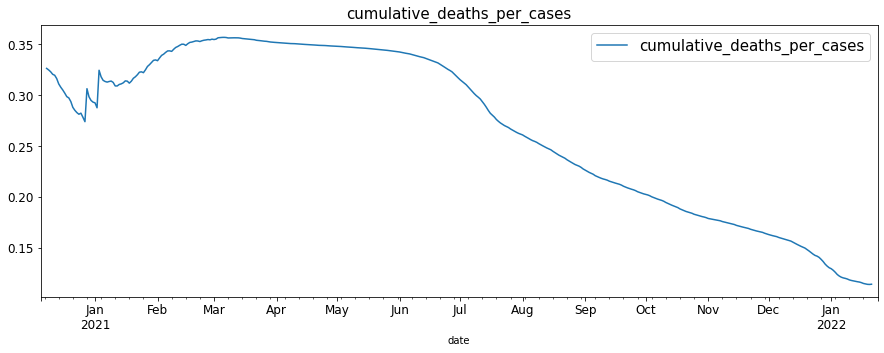

In [20]:
# create a new column, cumulative_deaths_per_cases, showing the ratio between cumulative_deaths and cumulative_cases.
covid_data["cumulative_deaths_per_cases"] = covid_data.apply(lambda row: row.cumulative_deaths / row.cumulative_cases, axis=1)

# 1. Aggregate the data as an intermediate dataframe
cumulative_deaths_per_cases_df = covid_data[["date", "cumulative_deaths_per_cases"]]
cumulative_deaths_per_cases_plot_df = cumulative_deaths_per_cases_df.groupby("date").sum()

# 2.Plot to visualised the transformed data
ax = cumulative_deaths_per_cases_plot_df.plot(figsize=(15,5),fontsize = 12)
plt.title("cumulative_deaths_per_cases", fontsize = 15)
plt.legend(loc=1, prop={'size': 15})
ax.set_xlim(min(cumulative_deaths_per_cases_plot_df.index) - pd.Timedelta(days=3), max(cumulative_deaths_per_cases_plot_df.index) + pd.Timedelta(days=3))


**3.Answer the question** <br>
Generally the ratio became smaller and smaller, that is to say COVID-19 mortality rate is decreasing. <br>
But as it shows in the graph, the ratio increased a bit from Jan 2021 to Feb 2021 and remain that level till June 2021. After June, and then the rate decreased continiously.


### Task 22
**Question** <br>
Based on the data and plot from the last question, it seems like, in June-July, the graphâ€™s inclination gets steeper. What could be a reasonable explanation?
<br>
<br>
**Answer the question** <br>
The reason could be as follows.
1. The new COVID variant is more contagious but less fatal, contributing the surge of daily new cases. While the daily new deaths cases did not increase that much.
2. The vaccination rate increased, more and more people are immune to COVID-19, therefore people were getting less volunrable. 
3. Hopsital and care center are more experienced in treating COVID patients. 



### Task23

(18601.0, 19016.0)

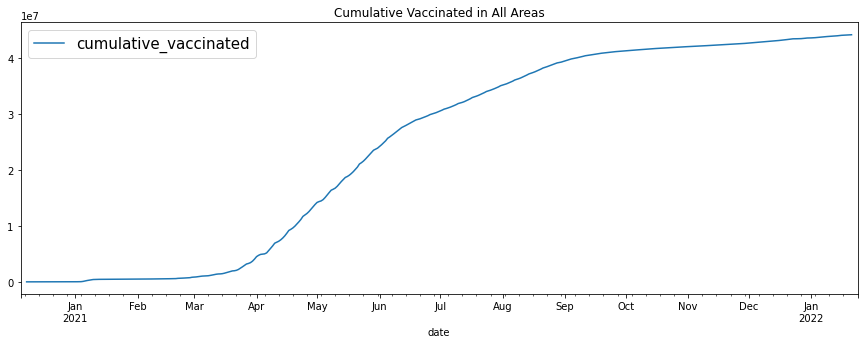

In [21]:
# 1. Aggregate the data as an intermediate dataframe
cumulative_vaccinations_df = covid_data[["date","cumulative_vaccinated"]]
cumulative_vaccinations_UK = cumulative_vaccinations_df.groupby("date").sum()

# 2.Plot to visualised the transformed data
ax = cumulative_vaccinations_UK.plot(figsize = (15, 5))
plt.title("Cumulative Vaccinated in All Areas")
plt.legend(loc=2, prop={'size': 15})
ax.set_xlim(min(cumulative_vaccinations_UK.index) - pd.Timedelta(days=3), max(cumulative_vaccinations_UK.index) + pd.Timedelta(days=3))



**3. Answer the question** <br>
Generally, two data are inversely proportional. The higher the number of cumulative vaccinated is, the number of lower cumulative deaths per cases is.  <br>
Firstly:<br>
Before March 2021, the death rate remained a high level, while cumulative_vaccinated remained low. 
As the the value of cumulative_vaccinated increased, the death ratio decreased.
So in conclusion,the higher the cumulative_vaccinated value, the lower the cumulative_deaths_per_cases. 
<br>
Secondly:<br>
We can see that the cumulative_vaccinated begin to increase fast around Apr, while the death ratio decreased fast around Jul.
The obvious decrease happened when the value of cumulative_vaccinated reached 3e+7, almost the half of UK's population.
In conclusion, high vaccinated ratio would contribute to death ratio decrease. 

### Task 24

(18601.0, 19016.0)

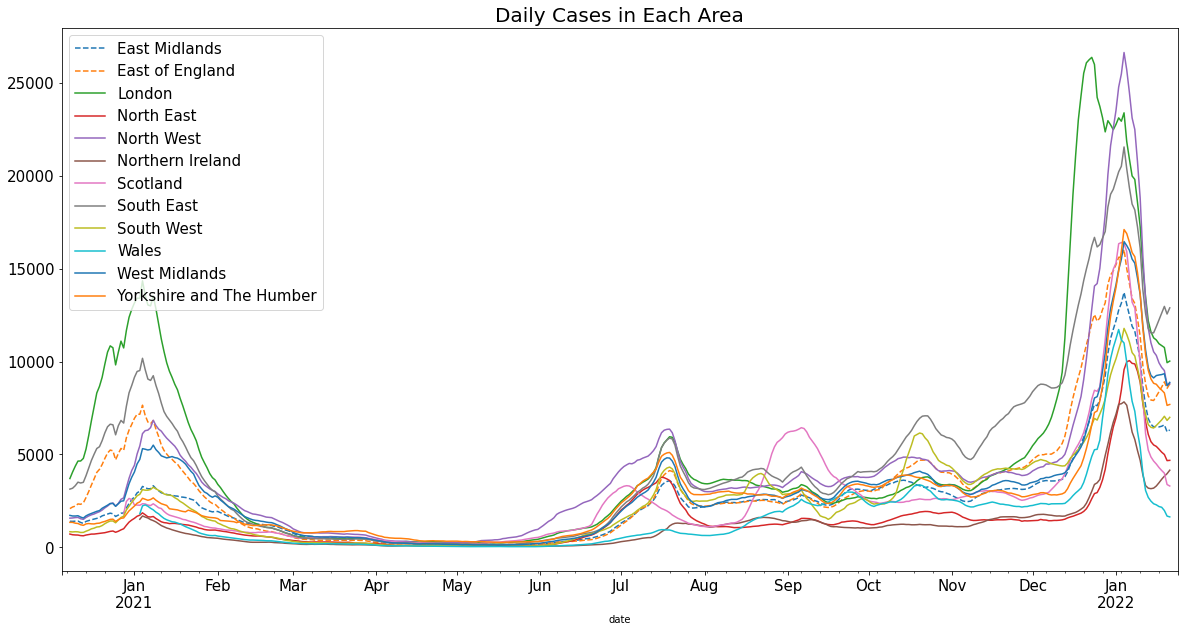

In [22]:
# 1. Aggregate the data as an intermediate dataframe
daily_cases_each_area = covid_data[["date",'area', "daily_cases_roll_avg"]].set_index(["date","area"]).unstack()
daily_cases_each_area.columns = daily_cases_each_area.columns.droplevel()

# 2.Plot to visualised the transformed data
# There are only 10 colors, so first 2 areset dashed 
ax = daily_cases_each_area.plot(figsize = (20,10), style = ["--" for _ in range(2)],fontsize = 15)
plt.legend(loc=2, prop={'size': 15})
plt.title("Daily Cases in Each Area", fontsize=20)
ax.set_xlim(min(daily_cases_each_area.index) - pd.Timedelta(days=3), max(daily_cases_each_area.index) + pd.Timedelta(days=3))


**3. Ansewer the question** <br>
The trend of rolling_avg_cases of Scotland escaped from the general ones. 
<br>
As the graph shows, the fluctuation of Scotland is different from the others. <br>
There was an obvious increase from Aug to Sept in the numbers of rolling_avg_cases of Scotland, while others did not.<br>
And, there was an obvious decrease from Sept to Oct in Scotland, while others did not.


### Task 25 

(18601.0, 19016.0)

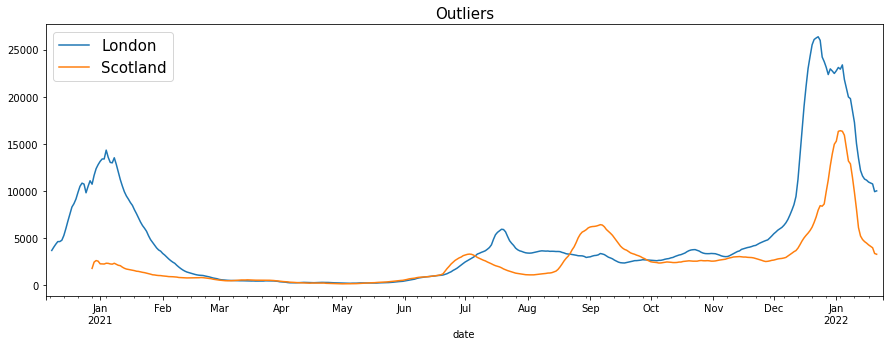

In [23]:
# 1. Aggregate the data as an intermediate dataframe
outlier_df = covid_data[(covid_data["area"] == "Scotland") | (covid_data["area"] == "London")][["date","area", "daily_cases_roll_avg"]].set_index(["date","area"]).unstack()
outlier_df.columns = outlier_df.columns.droplevel()

# 2.Plot to visualised the transformed data
ax = outlier_df.plot(figsize=(15,5))
plt.title("Outliers", fontsize = 15)
plt.legend(loc=2, prop={'size': 15})
ax.set_xlim(min(outlier_df.index) - pd.Timedelta(days=3), max(outlier_df.index) + pd.Timedelta(days=3)) 

**3. Answer the question** <br>
1. Geographical location might be one factor, since Scotland is the northernmost Country in UK. The temperature in Scotland is generally lower than others. Cold weather is contributing to the spread of virus as virus could survive longer in the air. Therefore the number of Scotland's rolling_avg_cases increased earlier than other areas.
2. The COVID policies might be different from other area. 

### Task 26

(18601.0, 19016.0)

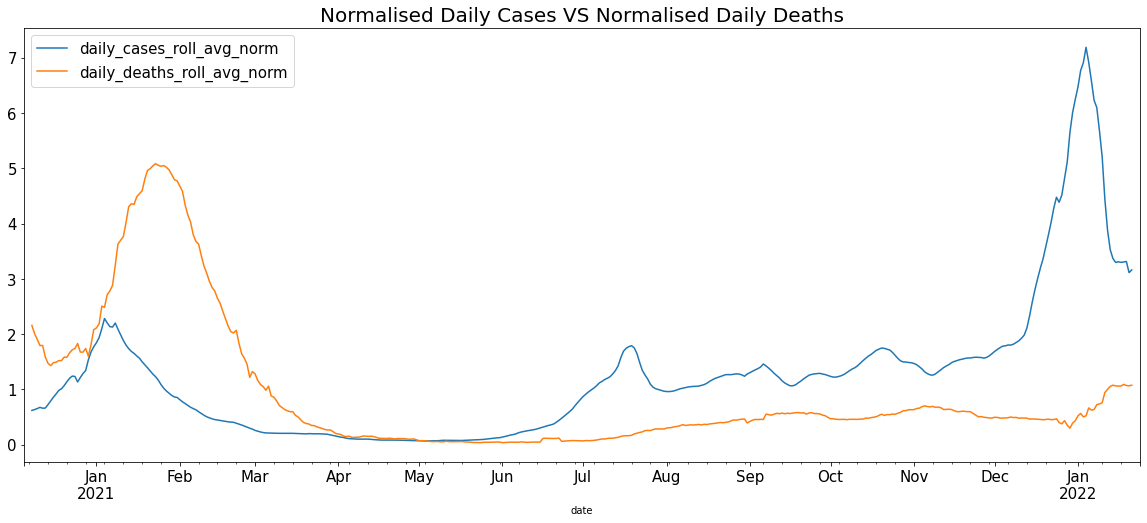

In [24]:
# Create 2 new columns
covid_data["daily_cases_roll_avg_norm"] = covid_data.apply(lambda row: row.daily_cases_roll_avg/covid_data.daily_cases_roll_avg.max(), axis=1)
covid_data["daily_deaths_roll_avg_norm"] = covid_data.apply(lambda row: row.daily_deaths_roll_avg/covid_data.daily_deaths_roll_avg.max(), axis=1)

# 1. Aggregate the data as an intermediate dataframe
norm_df = covid_data[["date", "daily_cases_roll_avg_norm", "daily_deaths_roll_avg_norm"]].groupby("date").sum()

# 2. Plot to visualised the transformed data
ax = norm_df.plot(figsize = (20,8), fontsize = 15)
plt.title("Normalised Daily Cases VS Normalised Daily Deaths", fontsize = 20)
plt.legend(loc=2, prop={'size': 15})
ax.set_xlim(min(norm_df.index) - pd.Timedelta(days=3), max(norm_df.index) + pd.Timedelta(days=3)) 


**3.Answer the question** <br>
They are partially increasing and descaresing at same rate. <br>
In the period between the end of 2020, and late Jan 2021, both of them increased at the same rate. <br>
But daily_cases_roll_avg_norm reached its peak at late Jan 2021, daily_deaths_roll_avg_norm still continued ascending and reached its peak in Feb. <br>
And the decreasing rate of daily_cases_roll_avg_norm from Feb to Apr 2021 was almost the same as that of daily_deaths_roll_avg_norm from late Jan to March. 
After Jun, daily_cases_roll_avg_norm started to increase again, while daily_deaths_roll_avg_norm remained almost the same.
<br>
In conclusion, there are periods when trends of these two were similar, but all the time.




# Task 27

(18601.0, 19015.0)

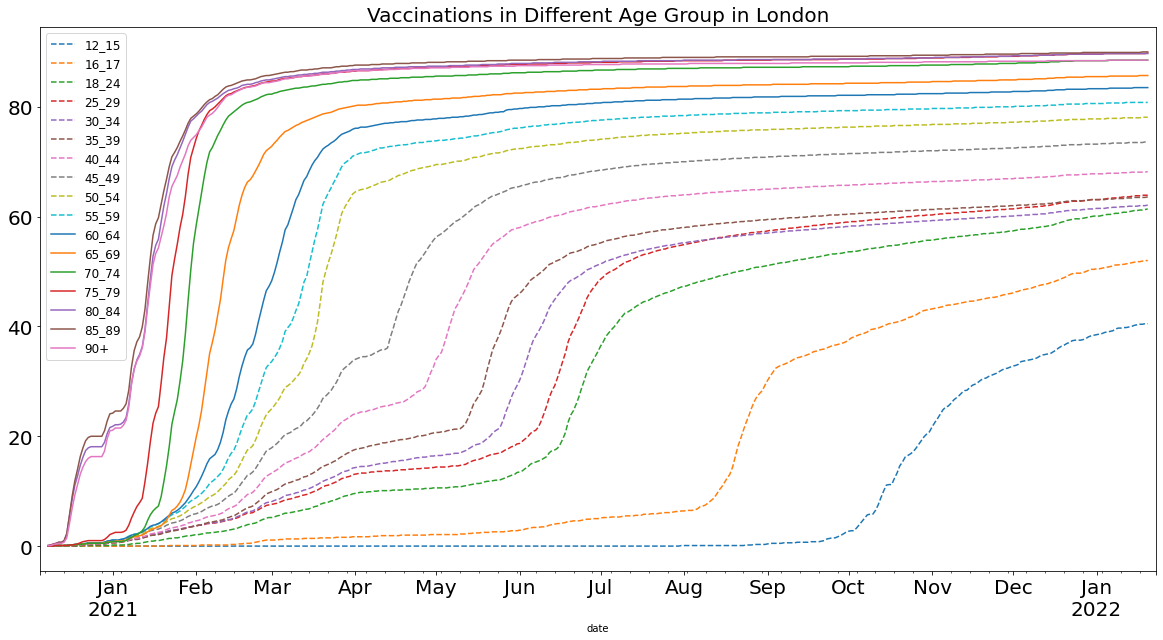

In [25]:
# 1. Aggregate the data as an intermediate dataframe

# split the dataframe into two.
covid_data_vaccinations_wide_london = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "London"]
covid_data_vaccinations_wide_scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide["area"] == "Scotland"]
# "Transpose" the dataframe
covid_data_vaccinations_wide_london_mould = covid_data_vaccinations_wide_london[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
covid_data_vaccinations_wide_london_mould = covid_data_vaccinations_wide_london_mould.set_index(["date","age"]).unstack()
# Drop the Hierarchy in index.
covid_data_vaccinations_wide_london_mould.columns = covid_data_vaccinations_wide_london_mould.columns.droplevel()

# 2. Plot to visualised the transformed data
ax = covid_data_vaccinations_wide_london_mould.plot(style = ['--' for _ in range(10)], figsize = (20,10),fontsize = 20)
plt.legend(loc=2, prop={'size': 12})
plt.title("Vaccinations in Different Age Group in London",fontsize = 20)
ax.set_xlim(min(covid_data_vaccinations_wide_london_mould.index) - pd.Timedelta(days=3), max(covid_data_vaccinations_wide_london_mould.index) + pd.Timedelta(days=3)) 



**3. Answer the question** <br>
No, the age groups are not vaccinated at the same time and not equally.<br> A strategy could be derived from the graph, that is the elderly got vacciniated preferentially.
Except for 90+ age group, almost the older the group, the earlier the group get vaccinated. 

# Task 28

(18621.0, 19015.0)

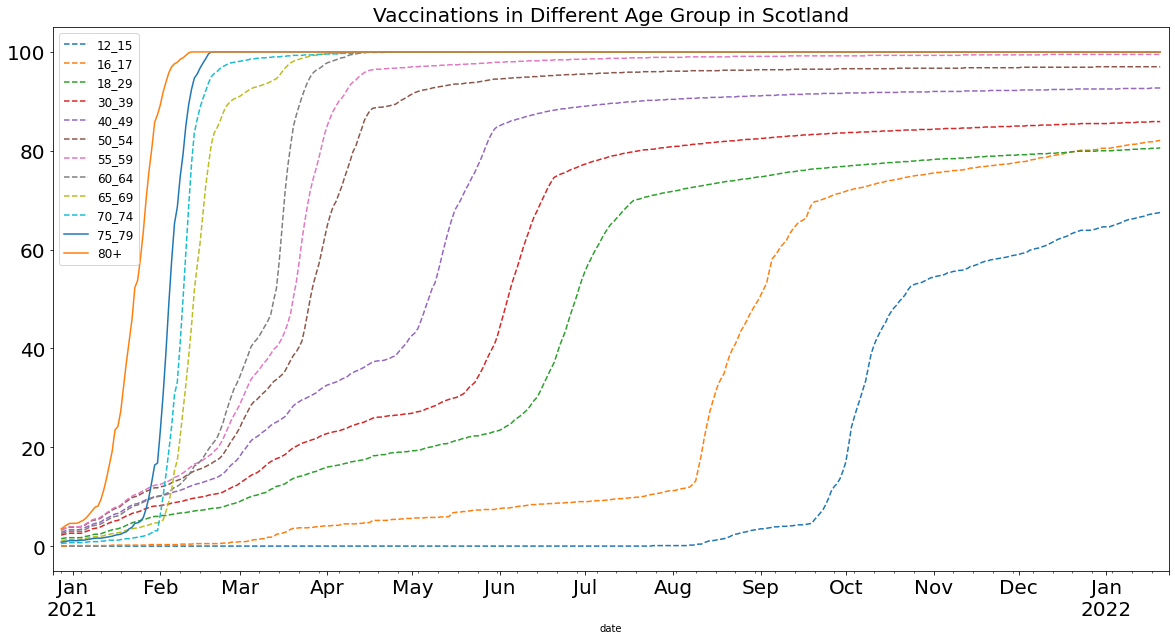

In [26]:
# 1. Aggregate the data as an intermediate dataframe
covid_data_vaccinations_wide_scotland_mould = covid_data_vaccinations_wide_scotland[["date", "age", "cumVaccinationFirstDoseUptakeByVaccinationDatePercentage"]]
covid_data_vaccinations_wide_scotland_mould = covid_data_vaccinations_wide_scotland_mould.set_index(["date","age"]).unstack()
covid_data_vaccinations_wide_scotland_mould.columns = covid_data_vaccinations_wide_scotland_mould.columns.droplevel()

# 2. Plot to visualised the transformed data
ax = covid_data_vaccinations_wide_scotland_mould.plot(style = ['--' for _ in range(10)], figsize = (20,10), fontsize = 20)
plt.legend(loc=2, prop={'size': 12})
plt.title("Vaccinations in Different Age Group in Scotland",fontsize = 20)
ax.set_xlim(min(covid_data_vaccinations_wide_scotland_mould.index) - pd.Timedelta(days=3), max(covid_data_vaccinations_wide_scotland_mould.index) + pd.Timedelta(days=3)) 



**3. Answer the question** <br>
According to the graph below, 2 strategies are very similar. Same age group's vaccination rate surged almost in the same time. 50-64 age group's vaccination rate surged from Jan 2021 to late April, while 65_79 age group's surged from Jan 2021 to late Feb.  <br>
The difference is, in London 65-79 age group's vaccination rate stayed at 80, while Scotland's stayed at almost 100. <br>
In London, 50-64 age group's vaccination rate stayed at 70, while Scotland's stayed at almost 100.


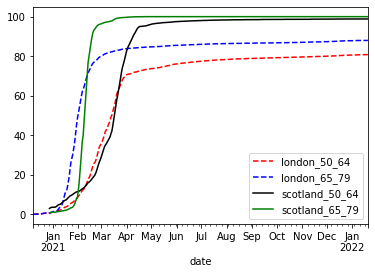

In [27]:
# To make screen the information
london_50_64 = covid_data_vaccinations_wide_london_mould[["50_54", "55_59", "60_64"]].sum(axis=1)/3
london_65_79 = covid_data_vaccinations_wide_london_mould[["65_69", "70_74", "75_79"]].sum(axis=1)/3
scotland_50_64 = covid_data_vaccinations_wide_scotland_mould[["50_54","55_59", "60_64"]].sum(axis=1)/3
scotland_65_79 = covid_data_vaccinations_wide_scotland_mould[["65_69","70_74", "75_79"]].sum(axis=1)/3
ax = london_50_64.plot(color = "red",label="london_50_64", style = "--")
london_65_79.plot(ax=ax, color = "blue", label = "london_65_79", style = "--")
scotland_50_64.plot(ax=ax, color="black", label = "scotland_50_64")
scotland_65_79.plot(ax=ax, color= "green", label = "scotland_65_79")
plt.legend()